# Consistency Checks
## Imports and Helpers

In [4]:
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import ast


from OpenAIModel import OpenAIModel
from DeepSeek import DeepSeek
from CodeQwen import CodeQwen
from ArtigenzCoder import ArtigenzCoder
from CodebleuCalculator import codebleu_score_calculator
from HelperFunction import validate_config, load_func_generation_prompts
from CodeMetricCalculator import get_loc, get_cog_complexity_py, get_cog_complexity_js, get_cc_py, get_cc_js, get_halstead_py, get_halstead_js


In [11]:
sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'serif'

---

## Getting The Sample for Testing

In [2]:
model_names = [
    "GPT-3_5-Turbo", 
    "GPT-4", 
    "DeepSeek-Coder-V2", 
    "CodeQwen1_5-7B-Chat", 
    "Artigenz-Coder-DS-6_7B"
]
type_names = ["type1", "type2", "type3"]
repo_names = ["craftship_codebox-npm", "JuliaRegistries_TagBot", "laconiajs_laconia", "StackJanitor"]
num_functions_per_repo = [3, 1, 3, 3]


In [3]:
random.seed(0)
def constrained_sampling(models, repos, prompt_types):
    selected_combinations = []
    selected_repos = set()
    selected_prompt_types = set()
    
    for model in models:
        repo = random.choice(repos)
        while repo in selected_repos and len(selected_repos) < len(repos):
            repo = random.choice(repos)
        selected_repos.add(repo)

        prompt_type = random.choice(prompt_types)
        while prompt_type in selected_prompt_types and len(selected_prompt_types) < len(prompt_types):
            prompt_type = random.choice(prompt_types)
        selected_prompt_types.add(prompt_type)

        function_num = random.randint(1, num_functions_per_repo[repos.index(repo)])
        selected_combinations.append([model, repo, function_num, prompt_type])

    return selected_combinations

sampled_combinations = constrained_sampling(model_names, repo_names, type_names)

for i, combination in enumerate(sampled_combinations, 1):
    print(f"{i}: Model: {combination[0]}, Repo: {combination[1]}, Function Num: {combination[2]}, Prompt Type: {combination[3]}")


1: Model: GPT-3_5-Turbo, Repo: StackJanitor, Function Num: 1, Prompt Type: type2
2: Model: GPT-4, Repo: laconiajs_laconia, Function Num: 2, Prompt Type: type3
3: Model: DeepSeek-Coder-V2, Repo: JuliaRegistries_TagBot, Function Num: 1, Prompt Type: type1
4: Model: CodeQwen1_5-7B-Chat, Repo: craftship_codebox-npm, Function Num: 2, Prompt Type: type3
5: Model: Artigenz-Coder-DS-6_7B, Repo: JuliaRegistries_TagBot, Function Num: 1, Prompt Type: type2


---
## Config Setup
Note that the prompts are already saved in the repo, we just need to generate 3x functions

In [6]:
config_file_base_path = "/home/userName/SERC/LMM+Serverless/LLM-Serverless/experiments/"
config_files_paths = [f"{config_file_base_path}{repo}/function{i}/config.json" for _, repo, i, _ in sampled_combinations]

for idx, config_path in enumerate(config_files_paths):
    if not os.path.isfile(config_path):
        raise FileNotFoundError(f"Config file not found: {config_path}")
    
    with open(config_path, "r") as f:
        config = json.load(f)
        validate_config(config)
        sampled_combinations[idx].append(config)


len(sampled_combinations)


5

---
## Generation

In [10]:
model_dict = {
    "GPT-3_5-Turbo": OpenAIModel("gpt-3.5-turbo"), 
    "GPT-4": OpenAIModel("gpt-4"), 
    "DeepSeek-Coder-V2": DeepSeek(), 
    "CodeQwen1_5-7B-Chat": CodeQwen(), 
    "Artigenz-Coder-DS-6_7B": ArtigenzCoder()
    }


Loaded as API: https://userName-codeqwen1-5-7b-chat.hf.space ✔
Loaded as API: https://userName-artigenz-artigenz-coder-ds-6-7b.hf.space ✔


In [ ]:
for combination in tqdm(sampled_combinations, desc="Remaining configurations"):
    print("-----------------------------------")
    model, repo, function_num, prompt_type, conf = combination

    function_generation_prompt_type1, function_generation_prompt_type2, function_generation_prompt_type3 = load_func_generation_prompts(conf)
    function_generation_prompts = {
        "type1": function_generation_prompt_type1,
        "type2": function_generation_prompt_type2,
        "type3": function_generation_prompt_type3
    }

    generated_function_save_dirs = {
        "type1": "consistency/" + conf['generated_function_type1_save_dir'],
        "type2": "consistency/" + conf['generated_function_type2_save_dir'],
        "type3": "consistency/" + conf['generated_function_type3_save_dir']
    }

    generation_count = 3

    for i in range(1, generation_count + 1):
        generated_func = model_dict[model].generate(function_generation_prompts[prompt_type])
        filename = conf["chosen_function"].split(".")
        generated_function_save_filename = f"{filename[0]}_{i}.{filename[1]}"
        generated_function_save_path = f"{generated_function_save_dirs[prompt_type]}/{model}/GENERATED-{generated_function_save_filename}"
        model_dict[model].write_to_file(generated_function_save_path)
        
        print(f"Generated function {i} using {model} model saved to {generated_function_save_path}")


---
## Calculating CodeBLEU between the variations

In [7]:
languages = {
    "JS": "javascript",
    "python": "python",
    "TS": "javascript"
}


In [8]:
def get_function_paths(config:dict, model_name: str, prompt_type: str, generation_num: int=1):
    """Get the path to original code and generated code for a specific model and prompt type.

    Args:
        config (dict): The experiment config 
        model_name (str): name of model, one of ["GPT-3_5-Turbo", "GPT-4", "DeepSeek-Coder-V2", "CodeQwen1_5-7B-Chat", "Artigenz-Coder-DS-6_7B"]
        prompt_type (str): prompt type, one of ["type1", "type2", "type3"]
        generation_num (int): This is the generation_num th generated function. Defaults to 1.
    """
    generated_function_save_dirs = {
        "type1": "consistency/" + config['generated_function_type1_save_dir'],
        "type2": "consistency/" + config['generated_function_type2_save_dir'],
        "type3": "consistency/" + config['generated_function_type3_save_dir']
    }

    filename = config['chosen_function'].split(".")
    generated_function_save_filename = f"{filename[0]}_{generation_num}.{filename[1]}"
    generated_function_save_path = f"{generated_function_save_dirs[prompt_type]}/{model_name}/GENERATED-{generated_function_save_filename}"

    return generated_function_save_path


In [10]:
generation_count = 3

In [13]:
codebleu_scores = []

for combination in tqdm(sampled_combinations, desc="Combinations"):
    model_name, repo, function_num, prompt_type, conf = combination
    single_combination_codebleus = [] # (generation_count,) entries
    average_codebleu = 0

    path_to_gen_files = []
    for i in range(generation_count):
        path_to_gen_files.append(get_function_paths(conf, model_name, prompt_type, i+1))

    # 1,2; 2, 3 and 3, 1 codebleu
    for i in range(generation_count):
        func1 = path_to_gen_files[i]
        func2 = path_to_gen_files[(i+1)%generation_count]
        codebleu_score = codebleu_score_calculator(
            func1,
            func2,
            languages[conf['language']]
        )
        single_combination_codebleus.append(codebleu_score['codebleu'])

    average_codebleu = sum(single_combination_codebleus) / generation_count
    codebleu_scores.append([model_name, repo, function_num, prompt_type, average_codebleu, single_combination_codebleus])


Combinations: 100%|██████████| 5/5 [00:00<00:00, 25.73it/s]


In [14]:
codebleu_scores

[['GPT-3_5-Turbo',
  'StackJanitor',
  1,
  'type2',
  0.5500666371329874,
  [0.646992391476279, 0.5778897762686691, 0.425317743654014]],
 ['GPT-4',
  'laconiajs_laconia',
  2,
  'type3',
  0.4839712127756754,
  [0.4646285093663695, 0.5337801800744644, 0.4535049488861923]],
 ['DeepSeek-Coder-V2',
  'JuliaRegistries_TagBot',
  1,
  'type1',
  0.7802244692530316,
  [0.8785195044652396, 0.765510643194681, 0.696643260099174]],
 ['CodeQwen1_5-7B-Chat',
  'craftship_codebox-npm',
  2,
  'type3',
  0.618207376466977,
  [0.5305804564078374, 0.6507345405708642, 0.6733071324222292]],
 ['Artigenz-Coder-DS-6_7B',
  'JuliaRegistries_TagBot',
  1,
  'type2',
  0.3650753841874325,
  [0.3679385170769528, 0.36368823350884877, 0.36359940197649593]]]

In [15]:
avg_codebleus_per_model = {}
for i in range(len(model_names)):
    model_name = model_names[i]
    avg_codebleus_per_model[model_name] = codebleu_scores[i][4]

---

## Plots

In [ ]:
sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'serif'

In [17]:
consistency_codebleus_df = pd.DataFrame(codebleu_scores, columns=["Model", "Repo", "Function Num", "Prompt Type", "Average Codebleu", "Codebleus"])
consistency_codebleus_df.head()

,Model,Repo,Function Num,Prompt Type,Average Codebleu,Codebleus
0,GPT-3_5-Turbo,StackJanitor,1,type2,0.550067,"[0.646992391476279, 0.5778897762686691, 0.4253..."
1,GPT-4,laconiajs_laconia,2,type3,0.483971,"[0.4646285093663695, 0.5337801800744644, 0.453..."
2,DeepSeek-Coder-V2,JuliaRegistries_TagBot,1,type1,0.780224,"[0.8785195044652396, 0.765510643194681, 0.6966..."
3,CodeQwen1_5-7B-Chat,craftship_codebox-npm,2,type3,0.618207,"[0.5305804564078374, 0.6507345405708642, 0.673..."
4,Artigenz-Coder-DS-6_7B,JuliaRegistries_TagBot,1,type2,0.365075,"[0.3679385170769528, 0.36368823350884877, 0.36..."


In [6]:
consistency_codebleus_df.to_csv("csvs/consistency/consistency_Codebleu.csv", index=False)

In [9]:
consistency_codebleus_df['Codebleus'] = consistency_codebleus_df['Codebleus'].apply(lambda x: ast.literal_eval(x))
consistency_codebleus_df['codebleu1'] = consistency_codebleus_df['Codebleus'].apply(lambda x: x[0])
consistency_codebleus_df['codebleu2'] = consistency_codebleus_df['Codebleus'].apply(lambda x: x[1])
consistency_codebleus_df['codebleu3'] = consistency_codebleus_df['Codebleus'].apply(lambda x: x[2])

consistency_codebleus_df

,Model,Repo,Function Num,Prompt Type,Average Codebleu,Codebleus,codebleu1,codebleu2,codebleu3
0,GPT-3_5-Turbo,StackJanitor,1,type2,0.550067,"[0.646992391476279, 0.5778897762686691, 0.4253...",0.646992,0.577890,0.425318
1,GPT-4,laconiajs_laconia,2,type3,0.483971,"[0.4646285093663695, 0.5337801800744644, 0.453...",0.464629,0.533780,0.453505
2,DeepSeek-Coder-V2,JuliaRegistries_TagBot,1,type1,0.780224,"[0.8785195044652396, 0.765510643194681, 0.6966...",0.878520,0.765511,0.696643
3,CodeQwen1_5-7B-Chat,craftship_codebox-npm,2,type3,0.618207,"[0.5305804564078374, 0.6507345405708642, 0.673...",0.530580,0.650735,0.673307
4,Artigenz-Coder-DS-6_7B,JuliaRegistries_TagBot,1,type2,0.365075,"[0.3679385170769528, 0.36368823350884877, 0.36...",0.367939,0.363688,0.363599


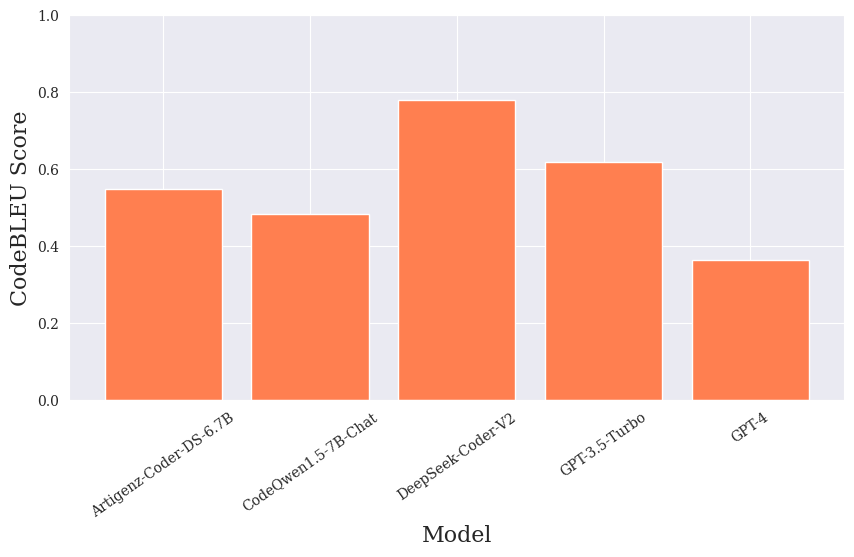

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.8

ax.bar(np.arange(len(consistency_codebleus_df["Model"])), consistency_codebleus_df["Average Codebleu"], color="coral", width=bar_width)
ax.set_xlabel("Model", fontsize=16)
ax.set_ylabel("CodeBLEU Score", fontsize=16)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(len(consistency_codebleus_df["Model"])))
ax.set_xticklabels(["Artigenz-Coder-DS-6.7B", "CodeQwen1.5-7B-Chat", "DeepSeek-Coder-V2", "GPT-3.5-Turbo", "GPT-4"], rotation=35)

plt.savefig("plots/consistency_codebleu_scores.png", dpi=1200, bbox_inches='tight')
plt.show()

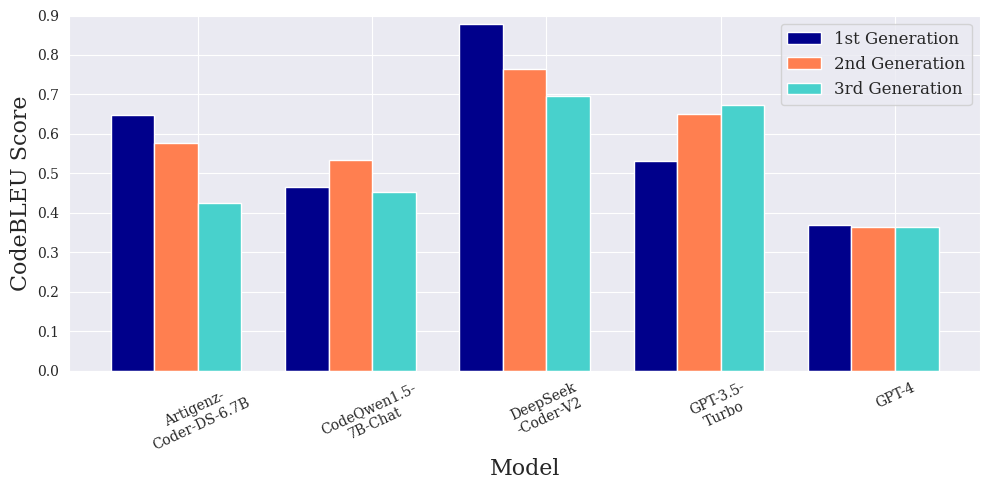

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["darkblue", "coral", "mediumturquoise"]
labels = ["1st Generation", "2nd Generation", "3rd Generation"]

bar_width = 0.25
x = np.arange(len(consistency_codebleus_df["Model"]))

for i, (label, color) in enumerate(zip(labels, colors)):
    ax.bar(x + i * bar_width, consistency_codebleus_df[f"codebleu{i+1}"], width=bar_width, label=label, color=color)

ax.set_xlabel("Model", fontsize=16)
ax.set_ylabel("CodeBLEU Score", fontsize=16)
ax.set_ylim(0, 0.9)
ax.set_xticks(x + bar_width * 1.5)
ax.set_xticklabels(["Artigenz-\nCoder-DS-6.7B", "CodeQwen1.5-\n7B-Chat", "DeepSeek\n-Coder-V2", "GPT-3.5-\nTurbo", "GPT-4"], rotation=25)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("plots/consistency_codebleu_scores.png", dpi=1200, bbox_inches='tight')
plt.show()

---
## Calculating code metrics between variations

In [19]:
measure_loc = True
measure_cyc_complexity = True
measure_cog_complexity = True
measure_halstead = True

In [23]:
loc_data = [] # repo_name, function_num, prompt_type, model, average_loc, locs
cc_data = [] # repo_name, function_num, prompt_type, model, average_cc, ccs
cog_data = [] # repo_name, function_num, prompt_type, model, average_cog, cogs
halstead_data = [] # repo_name, function_num, prompt_type, model, average_halstead, halsteads

In [24]:
cc_functions = {'python': get_cc_py, 'JS': get_cc_js, 'TS': get_cc_js}
cogc_functions = {'python': get_cog_complexity_py, 'JS': get_cog_complexity_js, 'TS': get_cog_complexity_js}
halstead_functions = {'python': get_halstead_py, 'JS': get_halstead_js, 'TS': get_halstead_js}

In [25]:
for combination in tqdm(sampled_combinations, desc="combinations"):
    model_name, repo, function_num, prompt_type, conf = combination
    single_combination_locs = []
    single_combination_ccs = []
    single_combination_cogs = []
    single_combination_halsteads = []
    average_loc, average_cc, average_cog, average_halstead = 0, 0, 0, 0

    path_to_gen_files = []
    for i in range(generation_count):
        path_to_gen_files.append(get_function_paths(conf, model_name, prompt_type, i+1))

    for i in range(generation_count):
        print(f"calculating metrics for {repo}-func-{function_num}-prompt-{prompt_type}-model-{model_name}-gen-{i+1}")
        loc = get_loc(path_to_gen_files[i])
        cc = cc_functions[conf['language']](path_to_gen_files[i])
        cog = cogc_functions[conf['language']](path_to_gen_files[i])
        halstead = halstead_functions[conf['language']](path_to_gen_files[i])

        single_combination_locs.append(loc)
        single_combination_ccs.append(cc)
        single_combination_cogs.append(cog)
        single_combination_halsteads.append(halstead)

    average_loc = sum(single_combination_locs) / generation_count
    average_cc = sum(single_combination_ccs) / generation_count
    average_cog = sum(single_combination_cogs) / generation_count
    average_halstead = sum(single_combination_halsteads) / generation_count

    loc_data.append([repo, function_num, prompt_type, model_name, average_loc, single_combination_locs])
    cc_data.append([repo, function_num, prompt_type, model_name, average_cc, single_combination_ccs])
    cog_data.append([repo, function_num, prompt_type, model_name, average_cog, single_combination_cogs])
    halstead_data.append([repo, function_num, prompt_type, model_name, average_halstead, single_combination_halsteads])


combinations:   0%|          | 0/5 [00:00<?, ?it/s]

calculating metrics for StackJanitor-func-1-prompt-type2-model-GPT-3_5-Turbo-gen-1
calculating metrics for StackJanitor-func-1-prompt-type2-model-GPT-3_5-Turbo-gen-2
calculating metrics for StackJanitor-func-1-prompt-type2-model-GPT-3_5-Turbo-gen-3


combinations:  20%|██        | 1/5 [00:03<00:13,  3.36s/it]

calculating metrics for laconiajs_laconia-func-2-prompt-type3-model-GPT-4-gen-1
calculating metrics for laconiajs_laconia-func-2-prompt-type3-model-GPT-4-gen-2
calculating metrics for laconiajs_laconia-func-2-prompt-type3-model-GPT-4-gen-3


combinations:  40%|████      | 2/5 [00:06<00:08,  2.99s/it]

calculating metrics for JuliaRegistries_TagBot-func-1-prompt-type1-model-DeepSeek-Coder-V2-gen-1
calculating metrics for JuliaRegistries_TagBot-func-1-prompt-type1-model-DeepSeek-Coder-V2-gen-2
calculating metrics for JuliaRegistries_TagBot-func-1-prompt-type1-model-DeepSeek-Coder-V2-gen-3
calculating metrics for craftship_codebox-npm-func-2-prompt-type3-model-CodeQwen1_5-7B-Chat-gen-1
calculating metrics for craftship_codebox-npm-func-2-prompt-type3-model-CodeQwen1_5-7B-Chat-gen-2
calculating metrics for craftship_codebox-npm-func-2-prompt-type3-model-CodeQwen1_5-7B-Chat-gen-3


combinations: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it]

calculating metrics for JuliaRegistries_TagBot-func-1-prompt-type2-model-Artigenz-Coder-DS-6_7B-gen-1
calculating metrics for JuliaRegistries_TagBot-func-1-prompt-type2-model-Artigenz-Coder-DS-6_7B-gen-2
calculating metrics for JuliaRegistries_TagBot-func-1-prompt-type2-model-Artigenz-Coder-DS-6_7B-gen-3


In [26]:
avg_metrics_per_model = {}
for i in range(len(model_names)):
    model_name = model_names[i]
    avg_metrics_per_model[model_name] = {
        "LOC": loc_data[i][4],
        "CC": cc_data[i][4],
        "COG": cog_data[i][4],
        "Halstead": halstead_data[i][4]
    }

avg_metrics_per_model

{'GPT-3_5-Turbo': {'LOC': 16.0,
  'CC': 4.333333333333333,
  'COG': 1.3333333333333333,
  'Halstead': 305.66866666666664},
 'GPT-4': {'LOC': 38.333333333333336,
  'CC': 6.333333333333333,
  'COG': 3.3333333333333335,
  'Halstead': 1433.8326666666665},
 'DeepSeek-Coder-V2': {'LOC': 59.666666666666664,
  'CC': 17.0,
  'COG': 10.666666666666666,
  'Halstead': 76.12899592752422},
 'CodeQwen1_5-7B-Chat': {'LOC': 41.0,
  'CC': 3.3333333333333335,
  'COG': 6.333333333333333,
  'Halstead': 1308.3363333333334},
 'Artigenz-Coder-DS-6_7B': {'LOC': 45.666666666666664,
  'CC': 15.0,
  'COG': 11.0,
  'Halstead': 78.38534710851853}}

In [27]:
average_metrics_df = pd.DataFrame(avg_metrics_per_model, index=["LOC", "CC", "COG", "Halstead"]).T
average_metrics_df.to_csv("csvs/consistency_average_metrics.csv", index=True)
average_metrics_df.head()

,LOC,CC,COG,Halstead
GPT-3_5-Turbo,16.000000,4.333333,1.333333,305.668667
GPT-4,38.333333,6.333333,3.333333,1433.832667
DeepSeek-Coder-V2,59.666667,17.000000,10.666667,76.128996
CodeQwen1_5-7B-Chat,41.000000,3.333333,6.333333,1308.336333
Artigenz-Coder-DS-6_7B,45.666667,15.000000,11.000000,78.385347


In [30]:
loc_data_df = pd.DataFrame(loc_data, columns=["Repo", "Function Num", "Prompt Type", "Model", "Average LOC", "LOCs"])
cc_data_df = pd.DataFrame(cc_data, columns=["Repo", "Function Num", "Prompt Type", "Model", "Average CC", "CCs"])
cog_data_df = pd.DataFrame(cog_data, columns=["Repo", "Function Num", "Prompt Type", "Model", "Average COG", "COGs"])
halstead_data_df = pd.DataFrame(halstead_data, columns=["Repo", "Function Num", "Prompt Type", "Model", "Average Halstead", "Halsteads"])

In [31]:
dfs = [loc_data_df, cc_data_df, cog_data_df, halstead_data_df]
names = ["LOC", "CC", "COG", "Halstead"]
for i in range(len(dfs)):
    dfs[i].to_csv(f"csvs/consistency/consistency_{names[i]}.csv", index=False)

---